In [1]:
from fastai.vision import *
from pathlib import Path
from fastai.callbacks import *
import os
import matplotlib.pyplot as plt
import torch
import torchaudio
import IPython.display as ipd
from PIL import Image as PImage
import torchvision.transforms as T

/home/graphter/.local/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def getParams(sample_rate):
    n_fft = 400.0
    frame_length = n_fft / sample_rate * 1000.0
    frame_shift = frame_length / 2.0
    params = {
        "channel": 0,
        "dither": 0.0,
        "window_type": "hanning",
        "frame_length": frame_length,
        "frame_shift": frame_shift,
        "remove_dc_offset": False,
        "round_to_power_of_two": False,
        "sample_frequency": sample_rate,
    }
    return params

In [3]:
class Agent:
    def setPath(self, path):
        self.pathModel = path
    
    def loadModel(self, filename):
        self.net = load_learner(pathModel, file= filename)
    
    def deleteSilence(self, waveform, sample_rate):
        waveform = torchaudio.functional.vad(waveform, sample_rate = sample_rate, trigger_level = 5.0)
        waveform = torch.flip(waveform, [1])
        waveform = torchaudio.functional.vad(waveform, sample_rate = sample_rate, trigger_level = 5.0)
        waveform = torch.flip(waveform, [1])
        return waveform
     
    def toSpectrogram(self, waveform, sample_rate):
        #plt.figure()
        curDir = "tmp"
        if not os.path.exists(curDir):
            os.makedirs(curDir)
        spectrogramKaldi = torchaudio.compliance.kaldi.spectrogram(waveform, getParams(sample_rate))
        plt.axis('off')
        plt.imshow(spectrogramKaldi.t().numpy(), aspect='auto', cmap = 'magma')
        plt.savefig(curDir + "/fig.png", bbox_inches='tight')
    
    def predict(self, img):
        pred = self.net.predict(img)
        label = str(pred[0])
        return label

In [4]:
def getFilesInDirectory(directory):
    files = []
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            files.append(os.path.abspath(os.path.join(dirpath, f)))
    return files

In [5]:
def getInfo(path):
    head, fileName = os.path.split(path)
    head , curClass = os.path.split(head)
    return os.path.splitext(fileName)[0], curClass

In [6]:
agent = Agent()
pathModel= Path('/home/graphter/Speech Emotion Recognition/RAVDESS/RAVDESS_model_4emotions')

In [7]:
agent.setPath(pathModel)

In [8]:
agent.loadModel('model-71.2%.pkl')

In [9]:
pathData = 'datasetDiego'
files = getFilesInDirectory(pathData)
len(files)

120

In [10]:
i = 5
curFile = files[i]
nameFile , curClass = getInfo(curFile) 
waveform, sample_rate = torchaudio.load(curFile)

In [12]:
ipd.Audio(waveform,rate=sample_rate)

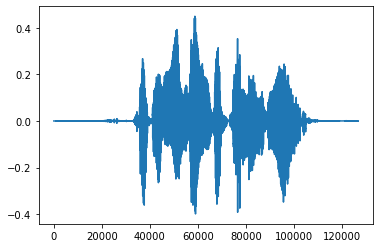

In [13]:
plt.figure()
plt.plot(waveform.t().numpy())

In [14]:
print("clase verdadera = ", curClass)

clase verdadera =  feliz


In [15]:
waveform2 = agent.deleteSilence(waveform, sample_rate)

/home/graphter/.local/lib/python3.7/site-packages/torchaudio/functional.py:2076: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  _dftBuf = torch.rfft(dftBuf, 1)


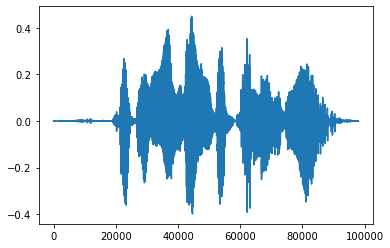

In [16]:
plt.figure()
plt.plot(waveform2.t().numpy())

In [16]:
ipd.Audio(waveform2,rate=sample_rate)

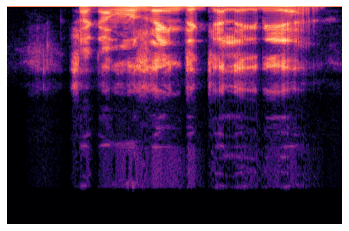

In [17]:
agent.toSpectrogram(waveform2, sample_rate)

In [18]:
img = PImage.open('tmp/fig.png').convert('RGB')
tensor = T.ToTensor()(img)
img = Image(tensor)
print("predicted = ", agent.predict(img))

predicted =  feliz


In [20]:
def plotConfusionMatrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True, nameFile = None):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" )
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" )


    plt.tight_layout()
    plt.xlabel('True label\naccuracy={:0.4f}; error={:0.4f}'.format(accuracy, misclass))
    plt.ylabel('Predicted label')

    if nameFile is not None:
        plt.savefig(nameFile)
    plt.show()


100%|██████████| 120/120 [06:47<00:00,  3.40s/it]


correct =  32
accuracy =  26.666666666666668 %


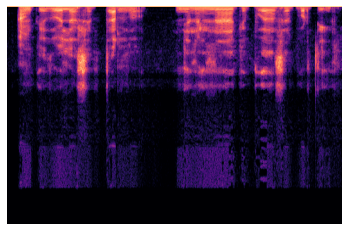

In [22]:
pathData = 'datasetDiego'
files = getFilesInDirectory(pathData)
from tqdm import tqdm
correct = 0
total = 0
y_true = []
y_pred = []
for i in tqdm(range(len(files))):
    curFile = files[i]
    #print("total = " , total)
    nameFile , curClass = getInfo(curFile) 
    waveform, sample_rate = torchaudio.load(curFile)
    waveform = agent.deleteSilence(waveform, sample_rate)
    agent.toSpectrogram(waveform, sample_rate)
    img = PImage.open('tmp/fig.png').convert('RGB')
    tensor = T.ToTensor()(img)
    img = Image(tensor)
    predicted = agent.predict(img)
    y_true.append(curClass)
    y_pred.append(predicted)
    if predicted == curClass:
        correct += 1
    total += 1

print("correct = " , correct)
print("accuracy = " , 100 * correct / total , "%")

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_pred, y_true, labels=["feliz", "molesto", "neutral", "triste"])

In [24]:
print("y_true = " , y_true)

y_true =  ['feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'molesto', 'triste', 'triste', 'triste', 'triste', 'triste', 'triste',

In [26]:
print("y_pred =", y_pred)

y_pred = ['feliz', 'neutral', 'neutral', 'feliz', 'feliz', 'feliz', 'neutral', 'neutral', 'feliz', 'feliz', 'neutral', 'neutral', 'feliz', 'feliz', 'neutral', 'feliz', 'neutral', 'feliz', 'neutral', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'feliz', 'neutral', 'feliz', 'feliz', 'neutral', 'feliz', 'feliz', 'neutral', 'feliz', 'feliz', 'feliz', 'neutral', 'neutral', 'feliz', 'feliz', 'feliz', 'neutral', 'neutral', 'neutral', 'feliz', 'feliz', 'neutral', 'feliz', 'feliz', 'feliz', 'neutral', 'feliz', 'feliz', 'feliz', 'neutral', 'feliz', 'neutral', 'feliz', 'feliz', 'feliz', 'neutral', 'neutral', 'neutral', 'feliz', 'neutral', 'neutral', 'feliz', 'feliz', 'neutral', 'feliz', 'feliz', 'feliz', 'neutral', 'feliz', 'feliz', 'neutral', 'feliz', 'feliz', 'neutral', 'neutral', 'feliz', 'neutral', 'neutral', 'neutral', 'neutral', 'feliz', 'feliz', 'feliz', 'feliz', 'neutral', 'neutral', 'neutral', 'feliz', 'neutral', 'feliz', 'neutral', 'feliz', 'feliz', 'feliz', 'feliz', '

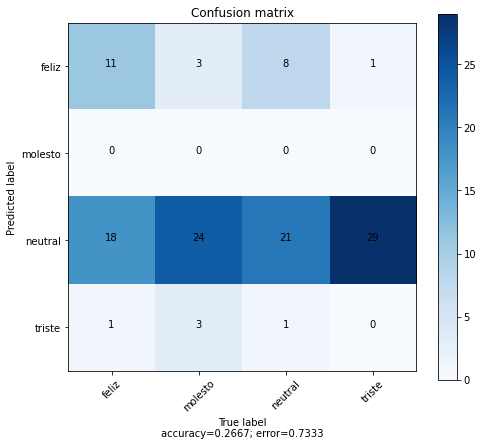

In [25]:
import numpy as np
plotConfusionMatrix(np.array(cm), target_names = ["feliz", "molesto", "neutral", "triste"], normalize = False)

In [17]:
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
correct = 0
total = 0
files = getFilesInDirectory('/home/graphter/Speech Emotion Recognition/RAVDESS/RAVDESS_spectrogram_Kaldi_4emotions/valid')
for i in tqdm(range(len(files))):
    curFile = files[i]
    #print("total = " , total)
    nameFile , curClass = getInfo(curFile) 
    img = PImage.open(curFile).convert('RGB')
    tensor = T.ToTensor()(img)
    img = Image(tensor)
    predicted = agent.predict(img)
    if predicted == curClass:
        correct += 1
    total += 1
    

print("correct = " , correct)
print("accuracy = " , 100 * correct / total , "%")

100%|██████████| 160/160 [00:04<00:00, 34.19it/s]

correct =  114
accuracy =  71.25 %
